In [1]:
!pip install torch torchmetrics torchsummary pytorch-lightning torchvision lightning diffusers datasets matplotlib opencv-python scikit-learn scikit-image

## (10 pt.) Implement and train (unconditional) Diffusion model using DDPM. Implement inference using DDIM. (pixel-based)
 (based on previous HW) you could use MNIST 
 (based on previous HW) try to use training pipeline from previous HW, but you could use pytorch lightning (or any other) tool for training

In [15]:
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image

from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [17]:
from models.blocks.sinusoidal_pos import SinusoidalPosEmb
from models.unconditional_unet import UnconditionalUNet
from models.diffusion_model import DiffusionModel

def get_dataloader(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t - 0.5) * 2) 
    ])
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


unet = UnconditionalUNet(in_channels=1, base_channels=64, time_emb_dim=128)
diffusion = DiffusionModel(unet, timesteps=1000, beta_start=1e-4, beta_end=0.02, lr=2e-4)

trainer = pl.Trainer(max_epochs=10, accelerator="gpu" if torch.cuda.is_available() else "cpu",
                        devices=1 if torch.cuda.is_available() else None)
dataloader = get_dataloader(batch_size=128)

trainer.fit(diffusion, dataloader)

samples = diffusion.sample(num_samples=16, ddim_steps=50)
save_image(samples, "unconditional_ddim_samples.png", nrow=4, normalize=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UnconditionalUNet | 4.0 M  | train
----------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.812    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


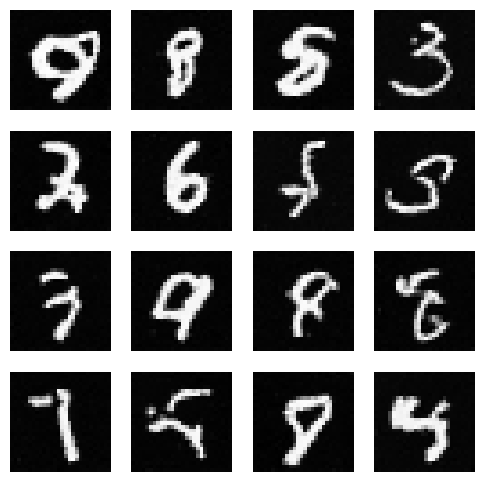

In [18]:
def plot_generated_images(images):
    images = images.detach().cpu().numpy()  
    fig, axes = plt.subplots(4, 4, figsize=(6, 6)) 
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, 0], cmap='gray') 
        ax.axis('off')  
    
    plt.show()

plot_generated_images(samples)

## (2 pt.) Using VAE from previous HW (re-train on MNIST if need) and diffusion implementation from above, implement and train latent diffusion model, compare inference from DDPM and DDIM


In [15]:
from models.vae import VAE
from models.ddpm_for_var import DDPM

vae = VAE()
ddpm = DDPM(vae=vae)


def ddim_sampling(ddpm, vae, num_samples=16, num_steps=50):
    z = torch.randn((num_samples, ddpm.latent_dim), device=ddpm.device)
    
    for t in reversed(range(num_steps)):
        pred_noise = ddpm(z, torch.full((num_samples,), t, device=ddpm.device))
        z = z - pred_noise / num_steps  # Simplified step
    
    x_recon = vae.decoder(vae.decoder_input(z).view(-1, 64, 7, 7))
    return x_recon

def get_dataloader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


dataloader = get_dataloader()
trainer = pl.Trainer(max_epochs=10, accelerator="auto")

print("Training VAE...")
trainer.fit(vae, dataloader)

print("Training DDPM...")
trainer.fit(ddpm, dataloader)


generated_images = ddim_sampling(ddpm, vae, num_samples=16)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | encoder       | Sequential | 33.4 K | train
1 | fc_mu         | Linear     | 62.7 K | train
2 | fc_logvar     | Linear     | 62.7 K | train
3 | decoder_input | Linear     | 65.9 K | train
4 | decoder       | Sequential | 33.3 K | train
-----------------------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.032     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Training VAE...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/venv/main/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /lightning_logs/version_4/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 5.3 K  | train
---------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=10` reached.


Training DDPM...


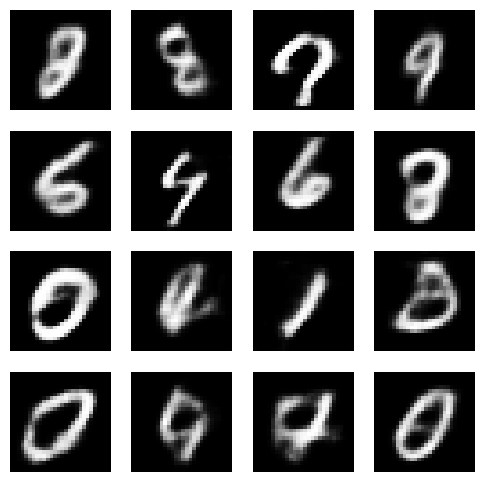

In [16]:
plot_generated_images(generated_images)

## (3 pt.) Implement and train classifier-free guidance using class label. Condition U-net thought input channel and using cross-attention


In [5]:

from models.conditional_unet import CombinedConditioningUNet


def get_dataloader(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t - 0.5) * 2)  # Scale images to [-1, 1]
    ])
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


unet = CombinedConditioningUNet(
    in_channels=1, base_channels=64, time_emb_dim=128,
    num_classes=10, class_emb_dim=32, attn_emb_dim=64
)
diffusion = DiffusionModel(
    unet, timesteps=1000, beta_start=1e-4, beta_end=0.02, lr=2e-4, drop_prob=0.1
)

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None
)
dataloader = get_dataloader(batch_size=128)

trainer.fit(diffusion, dataloader)

samples = diffusion.sample(num_samples=16, ddim_steps=50, desired_class=7, guidance_scale=5.0)
save_image(samples, "combined_conditioning_ddim_samples.png", nrow=4, normalize=True)
print("Sampling complete. Check 'combined_conditioning_ddim_samples.png' for generated images.")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | CombinedConditioningUNet | 4.1 M  | train
-----------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.549    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Sampling complete. Check 'combined_conditioning_ddim_samples.png' for generated images.


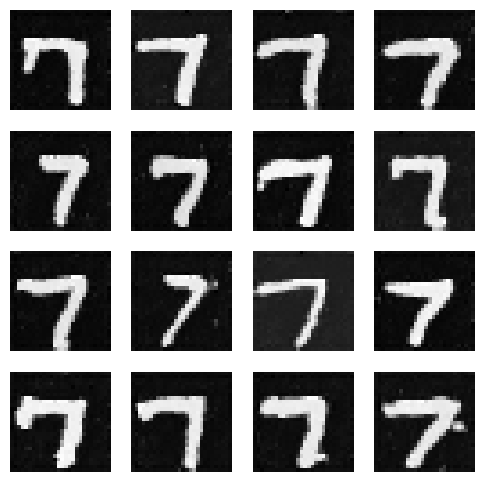

In [8]:
plot_generated_images(samples)

## (10pt.) Implement and train diffusion model (pixel and latent based) using Rectified Flow


Seed set to 42
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 3.3 M  | train
---------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.157    Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Training pixel-based diffusion model...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | encoder   | Encoder   | 520 K  | train
1 | decoder   | Decoder   | 454 K  | train
2 | diffusion | LatentMLP | 296 K  | train
------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.084     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training latent-based diffusion model...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Generating samples from pixel-based diffusion model...


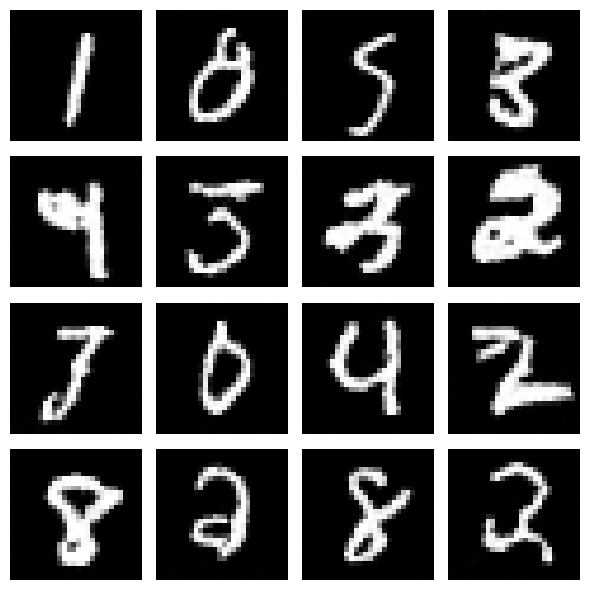

Generating samples from latent-based diffusion model...


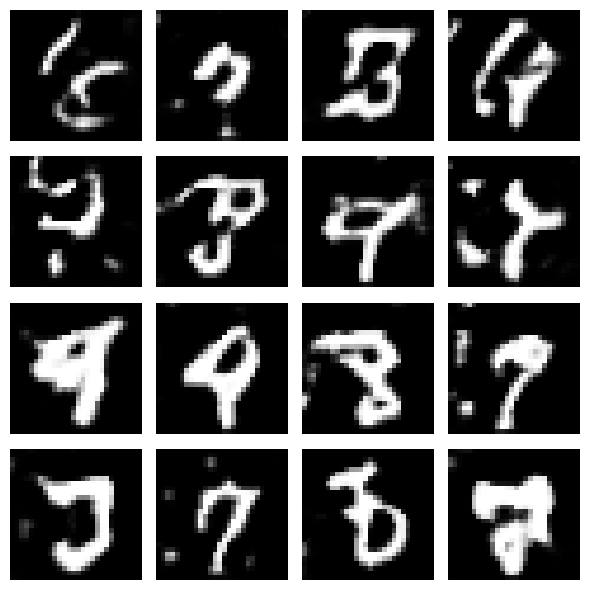

In [31]:
from models.enhanced_unet import UNet
from models.rectified_flow_diffusion import LatentRectifiedFlowDiffusion, RectifiedFlowDiffusion



class LatentMLP(nn.Module):
    def __init__(self, latent_dim=64, hidden_dim=256):
        super(LatentMLP, self).__init__()
        
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        self.net = nn.Sequential(
            nn.Linear(latent_dim + hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim),
        )
    
    def forward(self, x, t):
        t_embed = self.time_embed(t.unsqueeze(-1))
        x_t = torch.cat([x, t_embed], dim=-1)
        return self.net(x_t)



class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='./data', batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    
    def prepare_data(self):
        torchvision.datasets.MNIST(self.data_dir, train=True, download=True)
        torchvision.datasets.MNIST(self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        self.mnist_train = torchvision.datasets.MNIST(self.data_dir, train=True, transform=self.transform)
        self.mnist_val = torchvision.datasets.MNIST(self.data_dir, train=False, transform=self.transform)
    
    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=4)


def train_pixel_diffusion(max_epochs=50, batch_size=64, logdir='lightning_logs'):
    data_module = MNISTDataModule(batch_size=batch_size)
    
    model = RectifiedFlowDiffusion(batch_size=batch_size)
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='auto',  # Use GPU if available
        callbacks=[pl.callbacks.ModelCheckpoint(monitor='val_loss')]
    )
    
    trainer.fit(model, data_module)
    
    return model

def train_latent_diffusion(max_epochs=50, batch_size=64, latent_dim=64, logdir='lightning_logs'):
    data_module = MNISTDataModule(batch_size=batch_size)
    
    model = LatentRectifiedFlowDiffusion(batch_size=batch_size, latent_dim=latent_dim, img_size=28)
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='auto',  # Use GPU if available
        callbacks=[pl.callbacks.ModelCheckpoint(monitor='val_loss')]
    )
    
    trainer.fit(model, data_module)
    
    return model


def visualize_samples(model, num_samples=16, steps=100, is_latent=False):
    model.eval()
    with torch.no_grad():
        samples = model.generate_samples(num_samples=num_samples, steps=steps)
        
        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for i, ax in enumerate(axes.flatten()):
            if i < num_samples:
                ax.imshow(samples[i, 0].cpu().numpy(), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()


pl.seed_everything(42)

print("Training pixel-based diffusion model...")
pixel_model = train_pixel_diffusion(max_epochs=10, batch_size=64)

print("Training latent-based diffusion model...")
latent_model = train_latent_diffusion(max_epochs=10, batch_size=64, latent_dim=64)

print("Generating samples from pixel-based diffusion model...")
visualize_samples(pixel_model, num_samples=16)

print("Generating samples from latent-based diffusion model...")
visualize_samples(latent_model, num_samples=16, is_latent=True)

## (3pt.) Implement DeepCache for U-Net and research balance between skip steps and final result.


In [ ]:
from models.rectified_flow_diffusion_with_deepcache import RectifiedFlowDiffusionWithDeepCache

def train_model_with_deepcache(max_epochs=10, batch_size=64):
    data_module = MNISTDataModule(batch_size=batch_size)
    
    model = RectifiedFlowDiffusionWithDeepCache(batch_size=batch_size)
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='auto',  # Use GPU if available
        callbacks=[pl.callbacks.ModelCheckpoint(monitor='val_loss')]
    )
    
    trainer.fit(model, data_module)
    
    return model

def evaluate_deepcache(model, num_samples=16, steps=100):
    """Run benchmark tests for DeepCache with different skip step configurations"""
    print("Evaluating DeepCache performance...")
    
    cache_skip_steps = [1, 2, 4, 8, 16, 32]
    benchmark_results = model.benchmark_generation(
        num_samples=num_samples,
        steps=steps,
        cache_skip_steps_list=cache_skip_steps
    )
    
    model.visualize_benchmark_results(benchmark_results)
    
    print("\nDeepCache Performance Summary:")
    print("-" * 80)
    print(f"{'Method':<20} | {'Time (s)':<10} | {'Speedup':<10} | {'Quality (MSE)':<15}")
    print("-" * 80)
    
    for result in benchmark_results:
        method = result['method']
        time_taken = result['time']
        speedup = result.get('speedup', 1.0)
        similarity = result.get('similarity', 'N/A')
        
        print(f"{method:<20} | {time_taken:<10.2f} | {speedup:<10.2f}x | {similarity if similarity != 'N/A' else 'N/A':<15}")
    
    return benchmark_results


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNetWithDeepCache | 3.3 M  | train
----------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.157    Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Using device: cuda
Creating and training a model with DeepCache support...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Evaluating DeepCache performance...


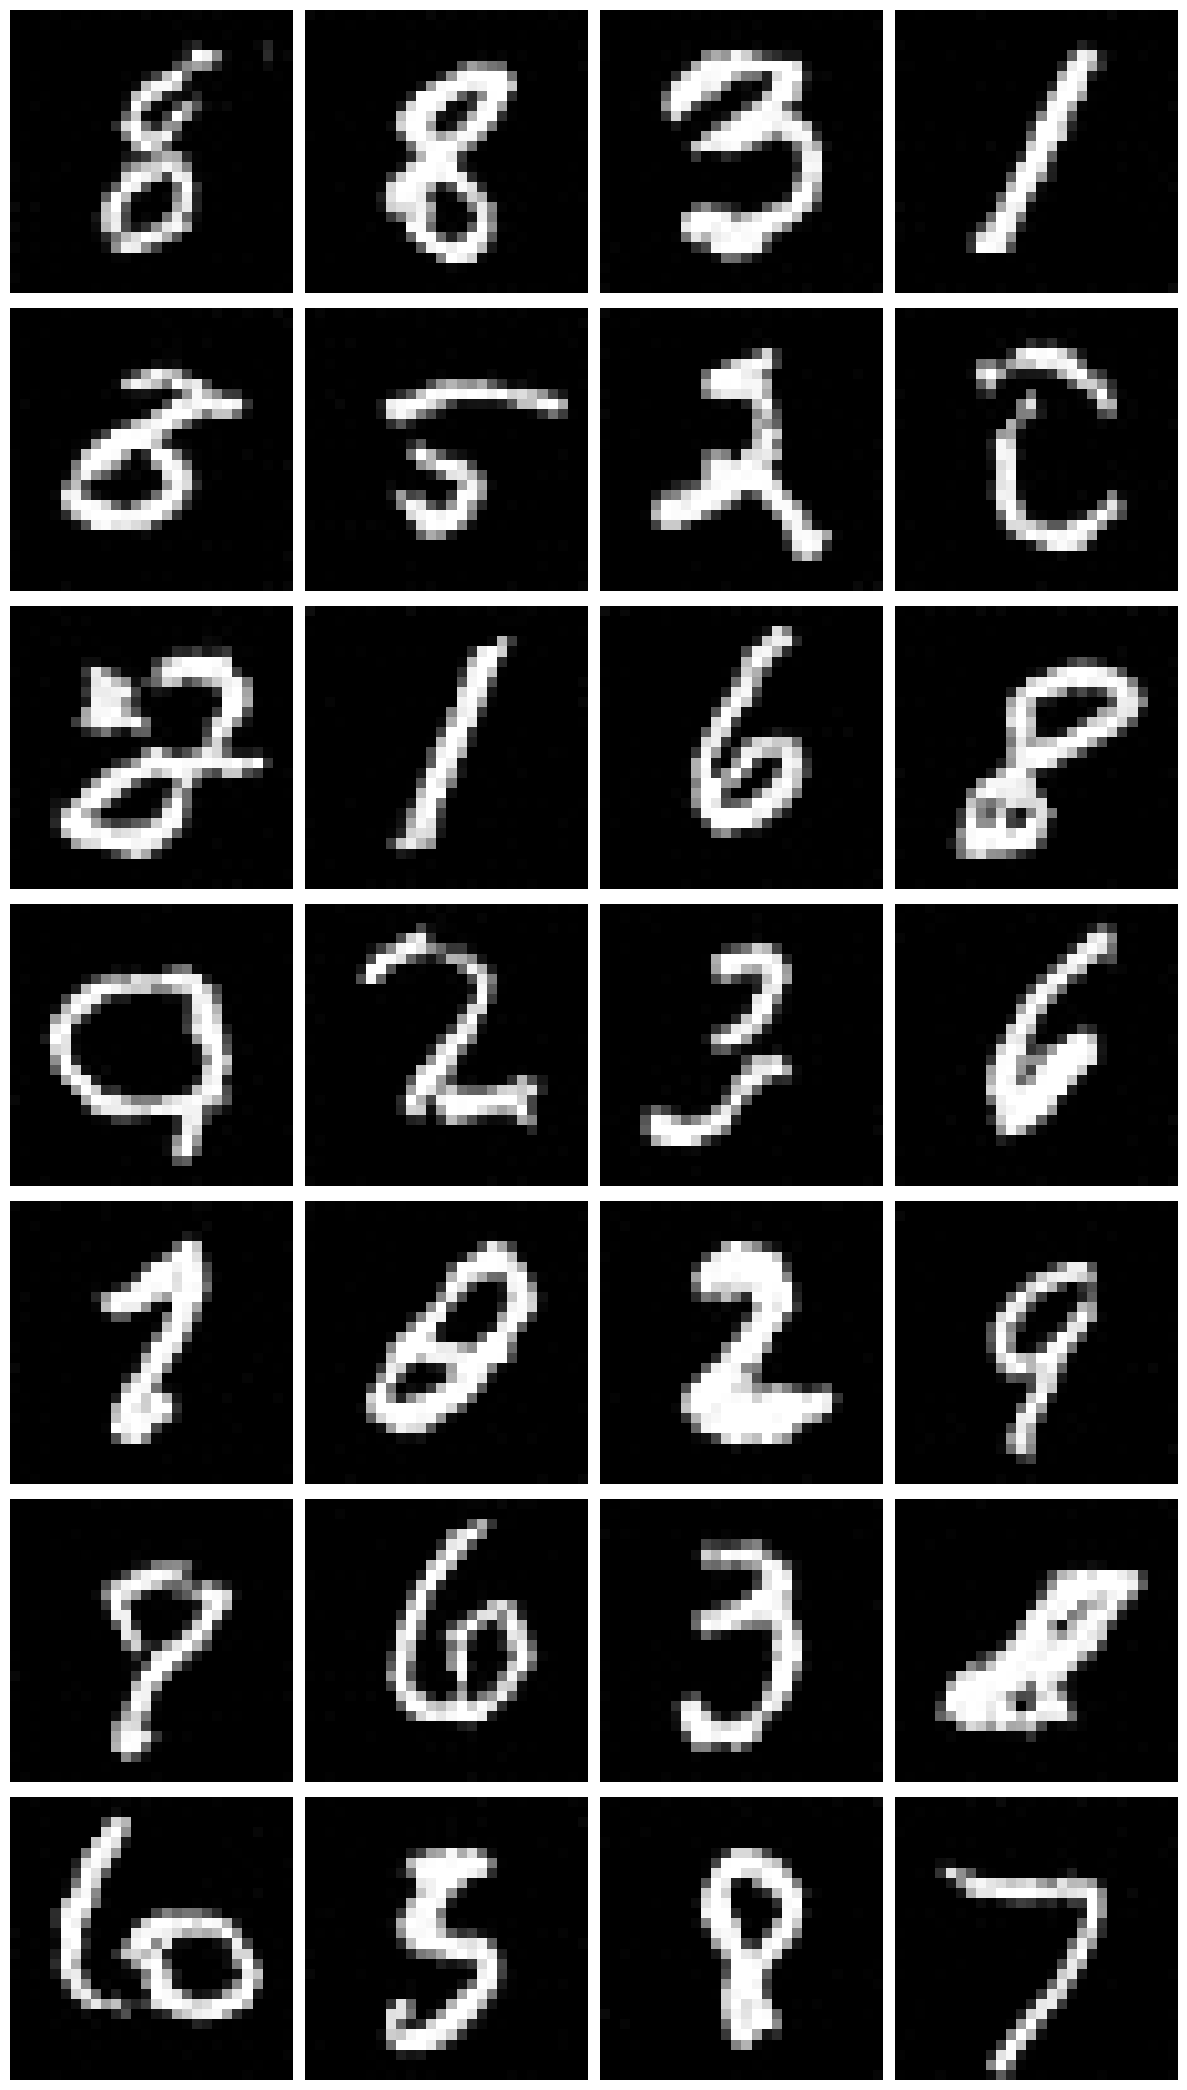

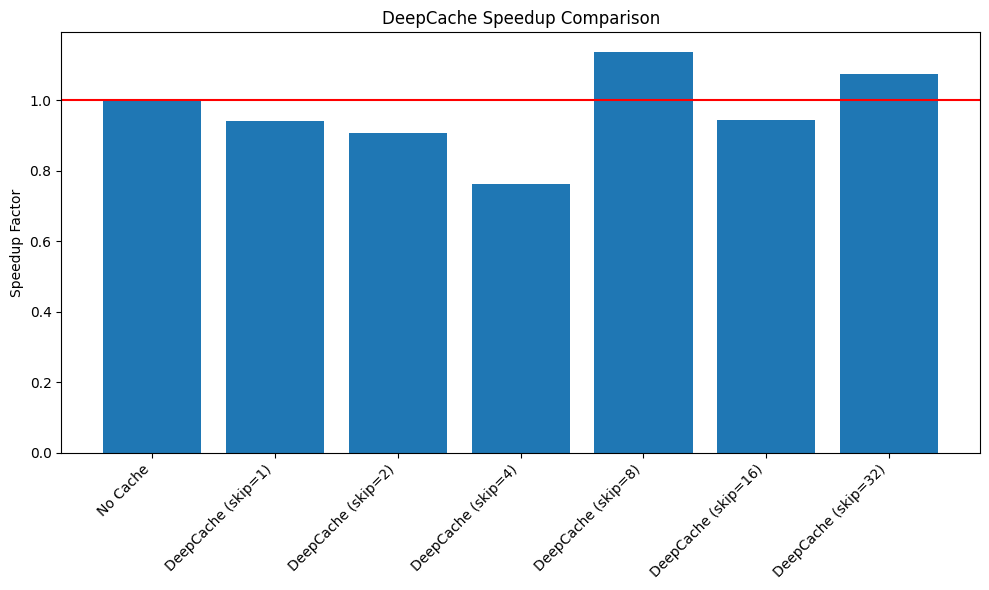


DeepCache Performance Summary:
--------------------------------------------------------------------------------
Method               | Time (s)   | Speedup    | Quality (MSE)  
--------------------------------------------------------------------------------
No Cache             | 8.19       | 1.00      x | N/A            
DeepCache (skip=1)   | 8.71       | 0.94      x | 0.10905640572309494
DeepCache (skip=2)   | 9.04       | 0.91      x | 0.11834027618169785
DeepCache (skip=4)   | 10.72      | 0.76      x | 0.11537489295005798
DeepCache (skip=8)   | 7.21       | 1.14      x | 0.10258403420448303
DeepCache (skip=16)  | 8.68       | 0.94      x | 0.10832442343235016
DeepCache (skip=32)  | 7.62       | 1.07      x | 0.1208278089761734

DeepCache experiment completed successfully!


In [22]:
pl.seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print("Creating and training a model with DeepCache support...")
model = train_model_with_deepcache(max_epochs=10)

benchmark_results = evaluate_deepcache(model, num_samples=16, steps=100)

print("\nDeepCache experiment completed successfully!")

Using device: cuda
Running DeepCache tradeoff analysis...
Generating baseline samples with 1 steps...
Generating samples with DeepCache (skip=1, steps=1)...
Generating samples with DeepCache (skip=2, steps=1)...
Generating samples with DeepCache (skip=4, steps=1)...
Generating samples with DeepCache (skip=8, steps=1)...
Generating samples with DeepCache (skip=16, steps=1)...
Generating samples with DeepCache (skip=32, steps=1)...
Generating samples with DeepCache (skip=64, steps=1)...
Generating samples with DeepCache (skip=128, steps=1)...
Generating baseline samples with 10 steps...
Generating samples with DeepCache (skip=1, steps=10)...
Generating samples with DeepCache (skip=2, steps=10)...
Generating samples with DeepCache (skip=4, steps=10)...
Generating samples with DeepCache (skip=8, steps=10)...
Generating samples with DeepCache (skip=16, steps=10)...
Generating samples with DeepCache (skip=32, steps=10)...
Generating samples with DeepCache (skip=64, steps=10)...
Generating sa

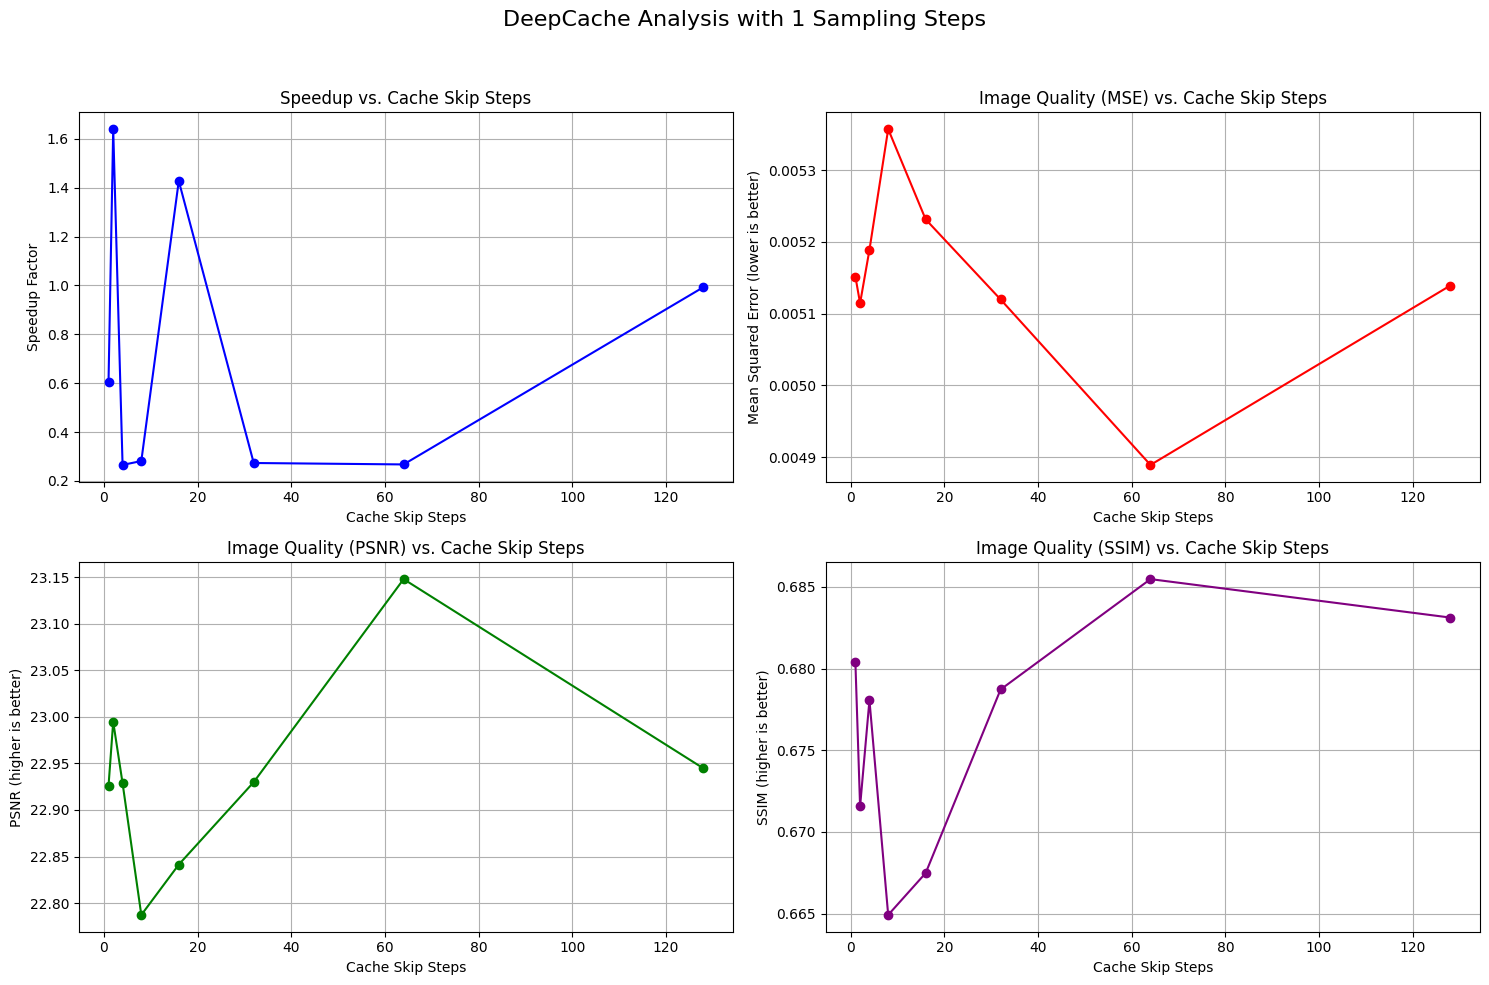

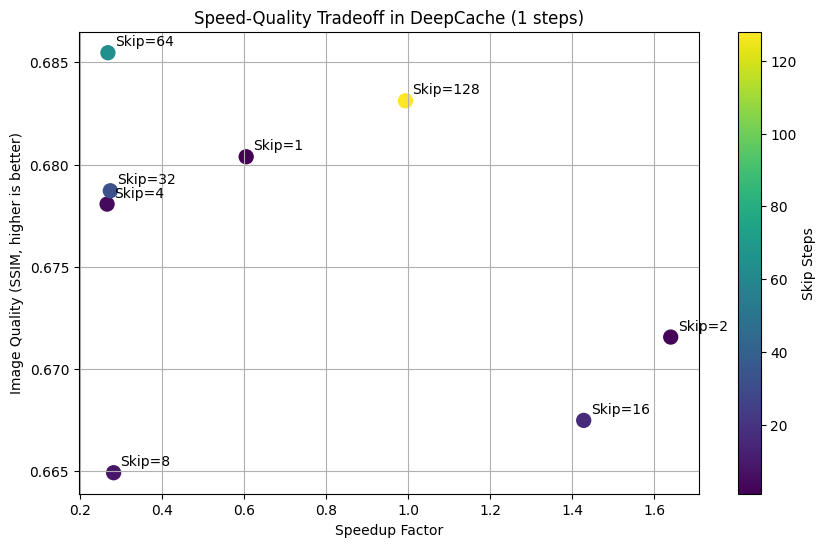

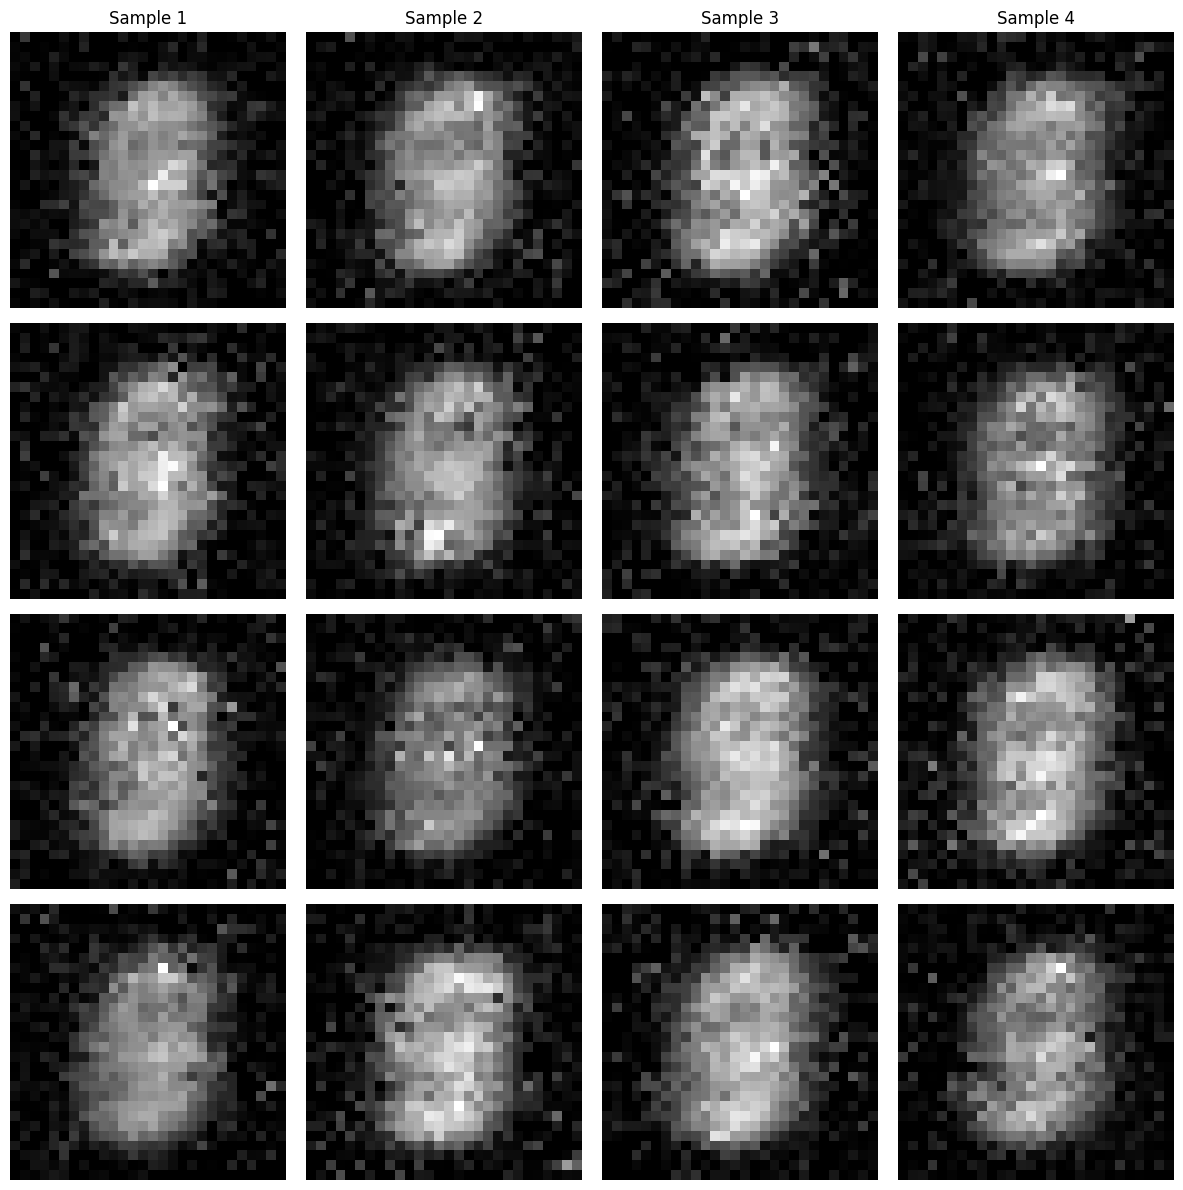

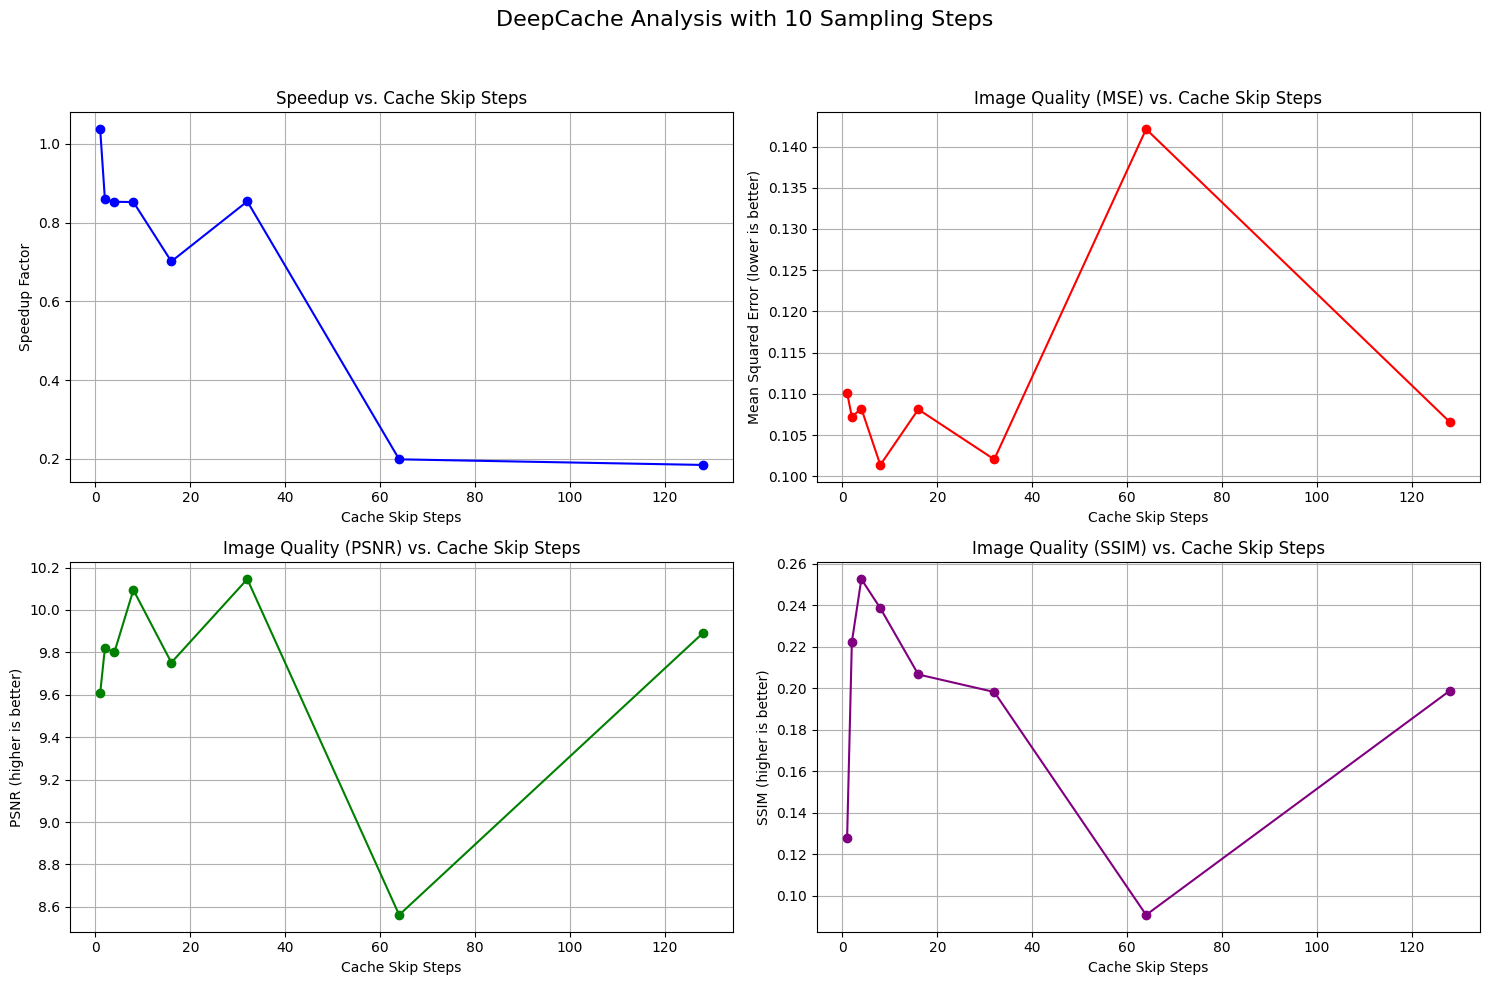

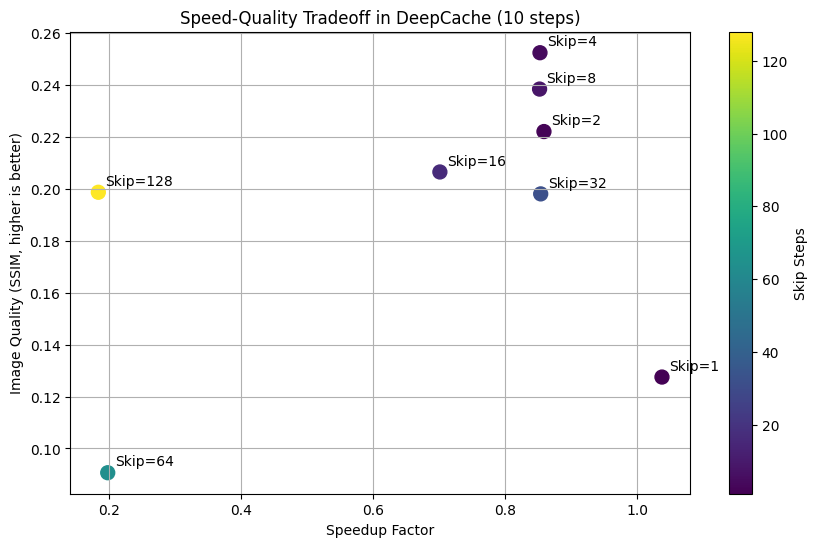

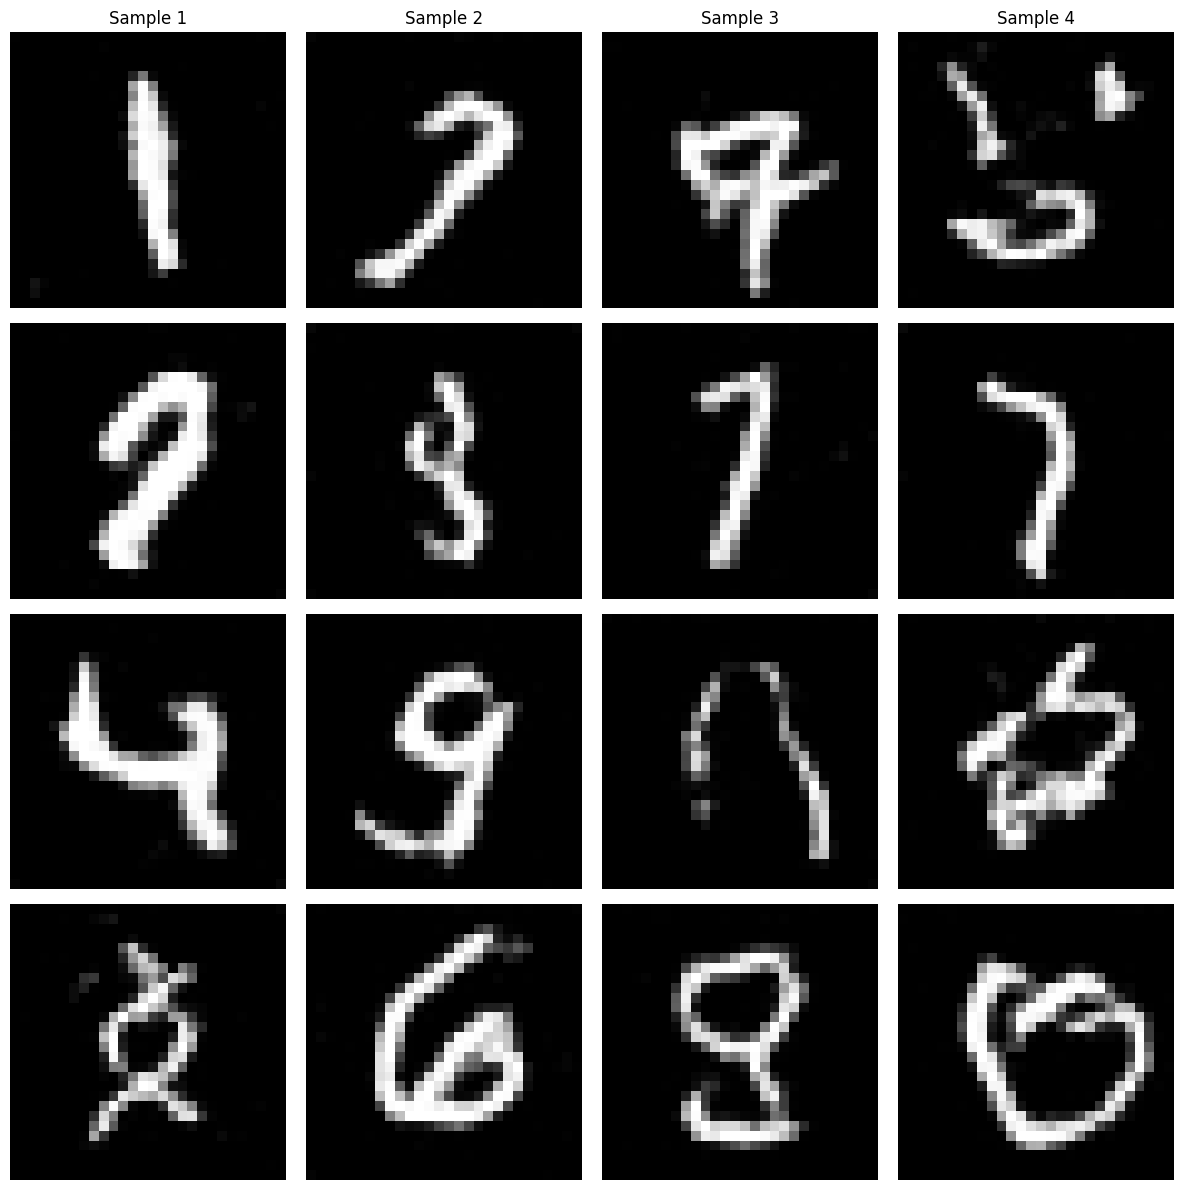

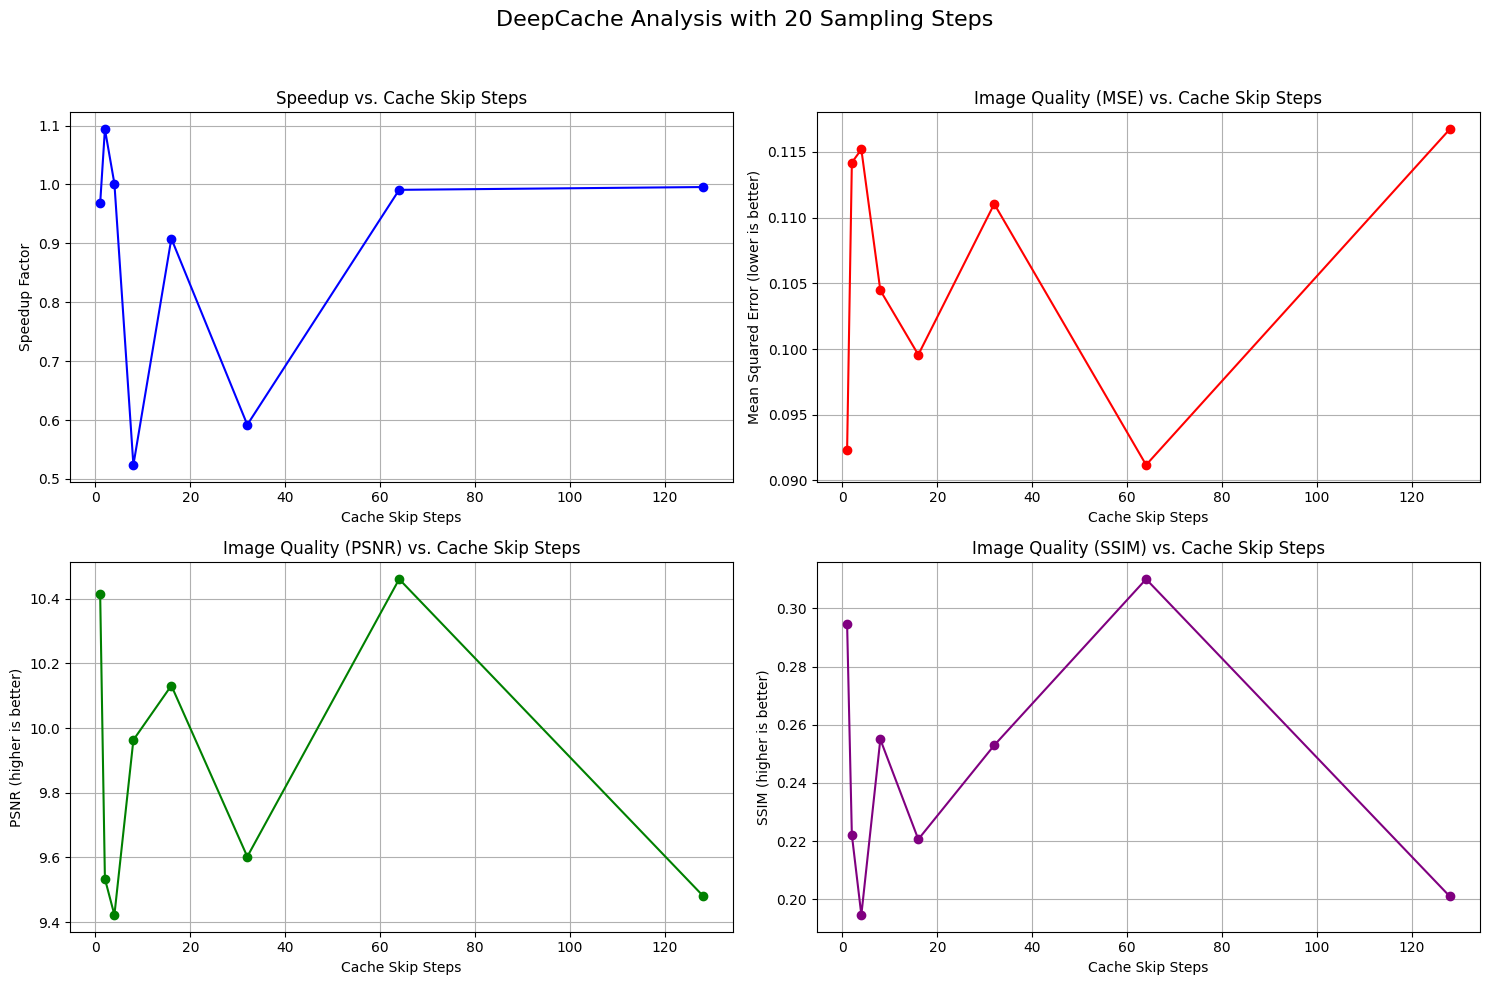

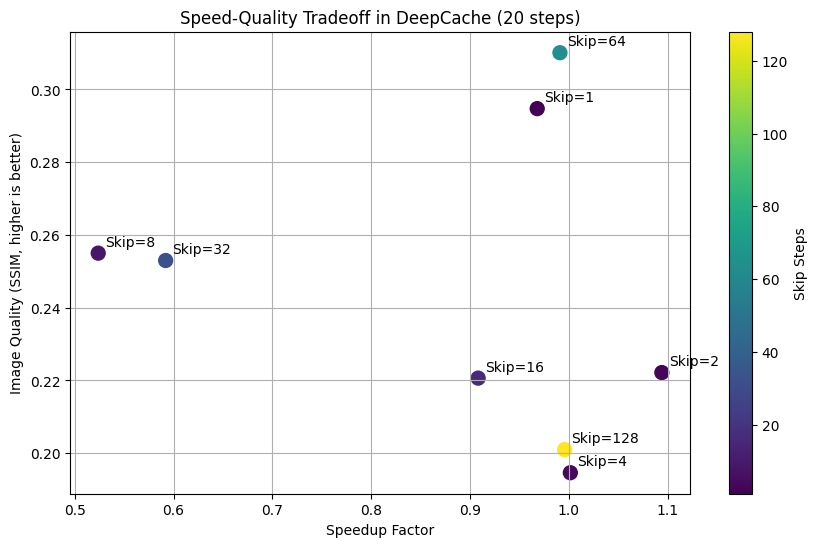

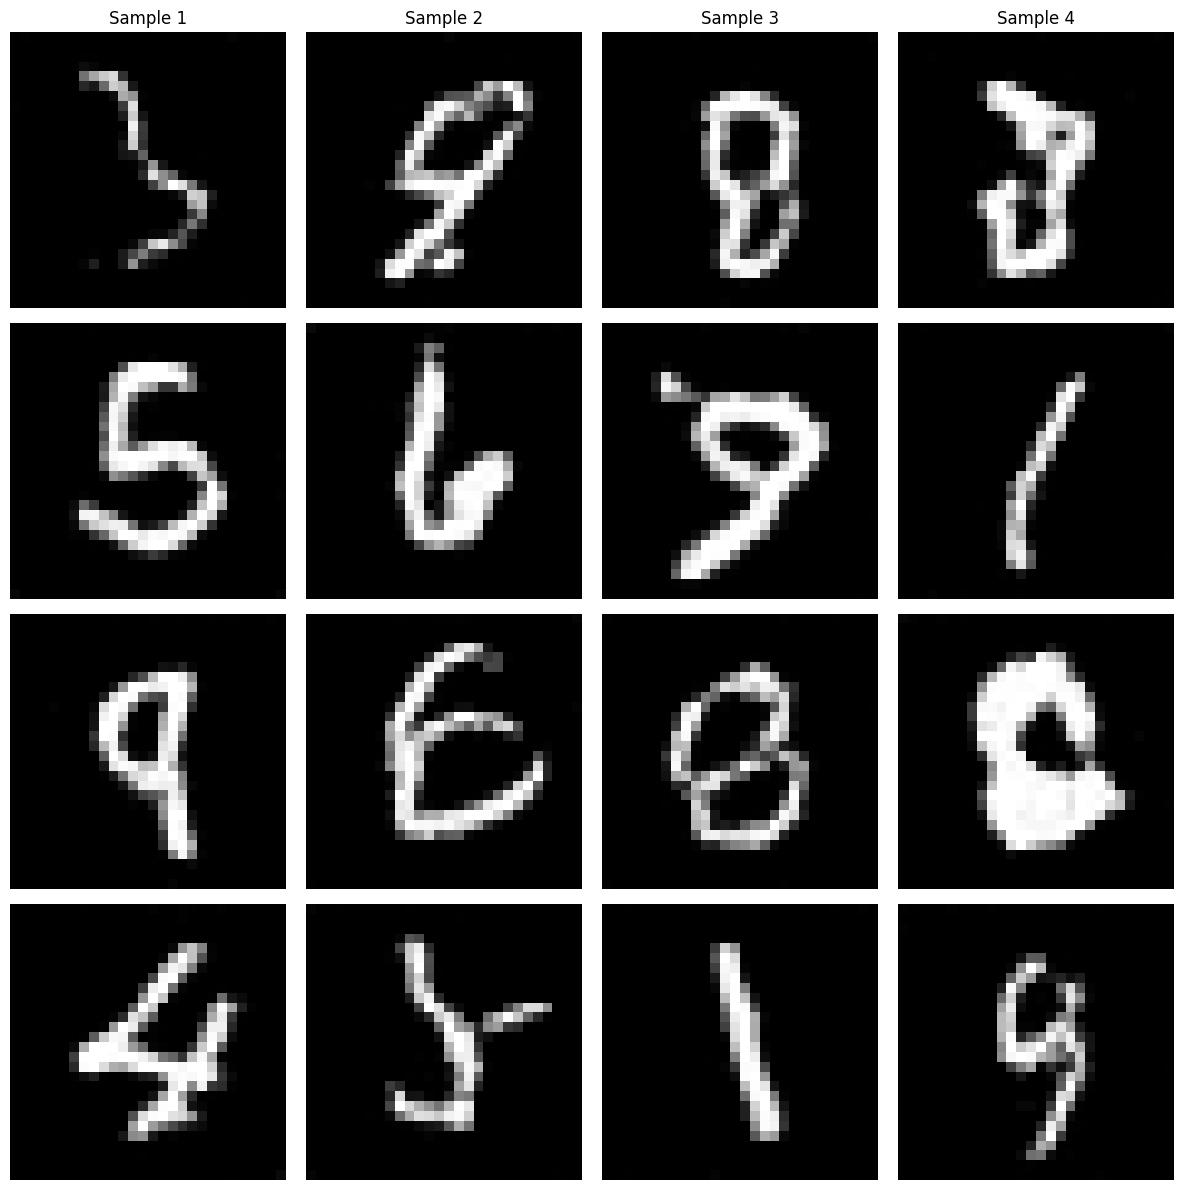

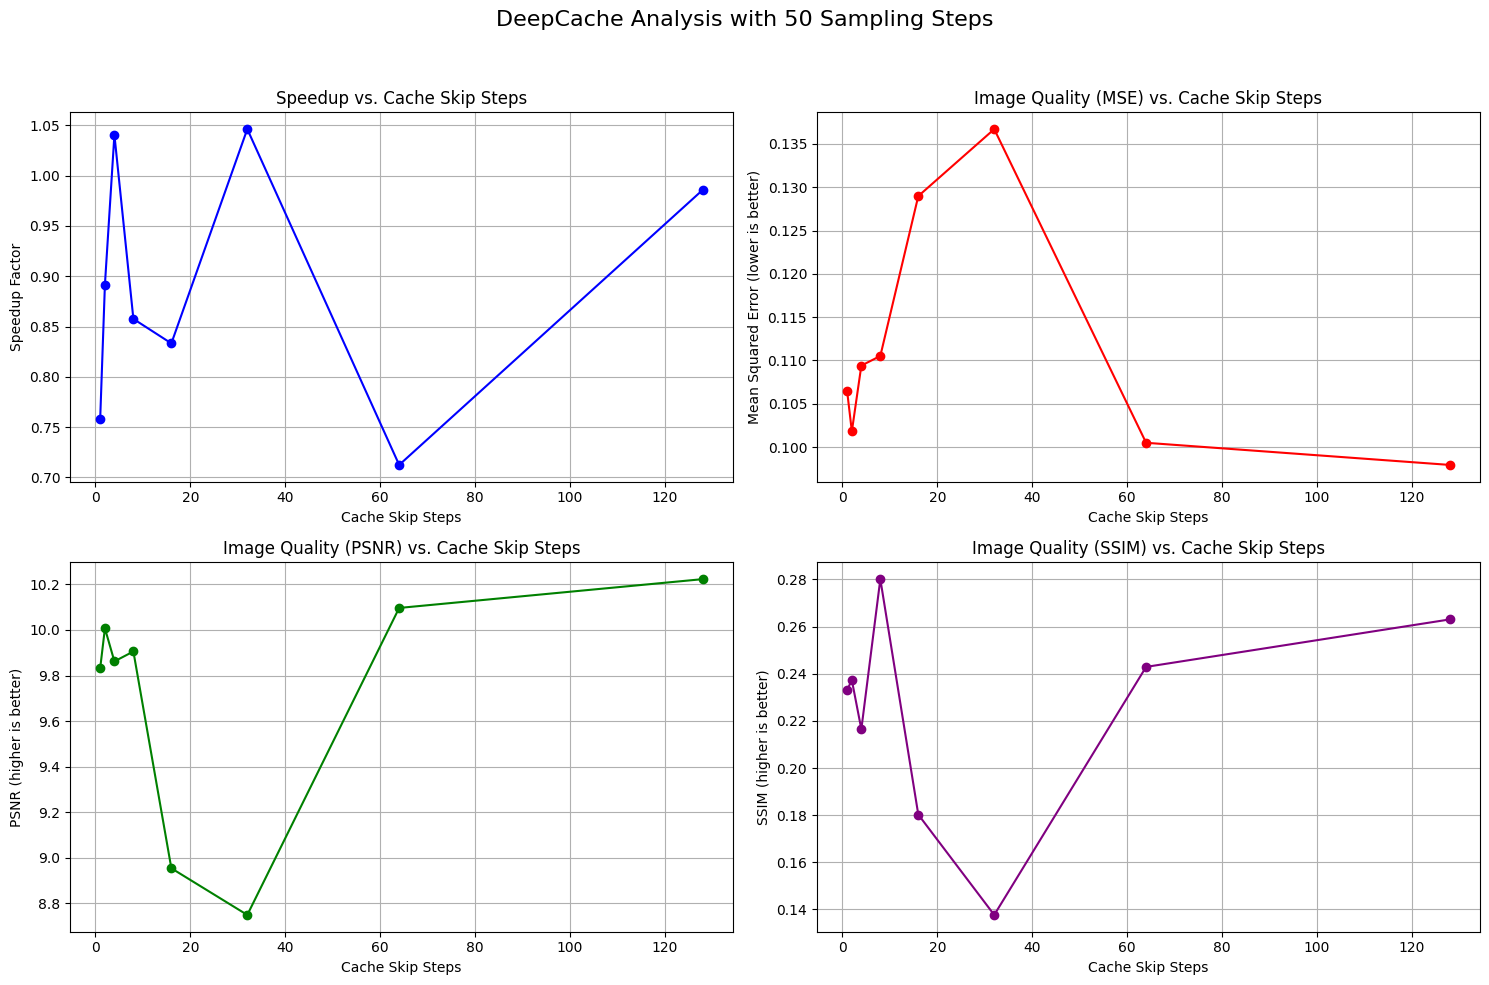

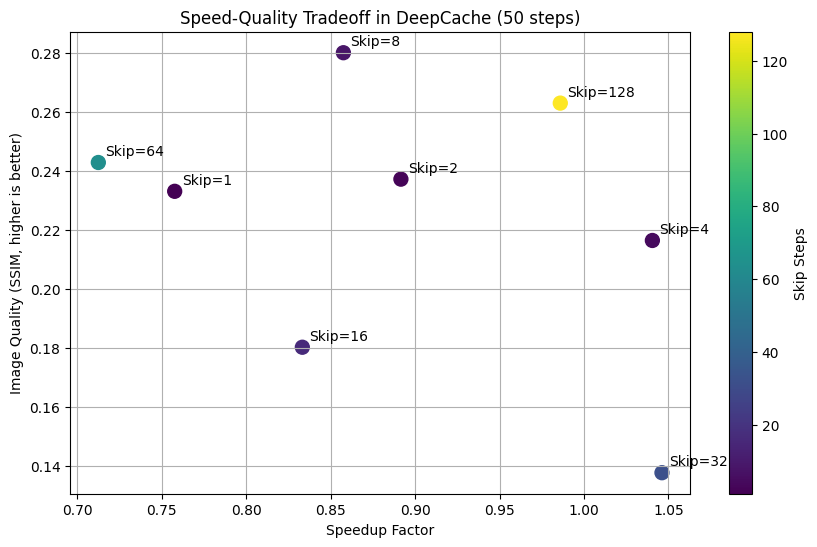

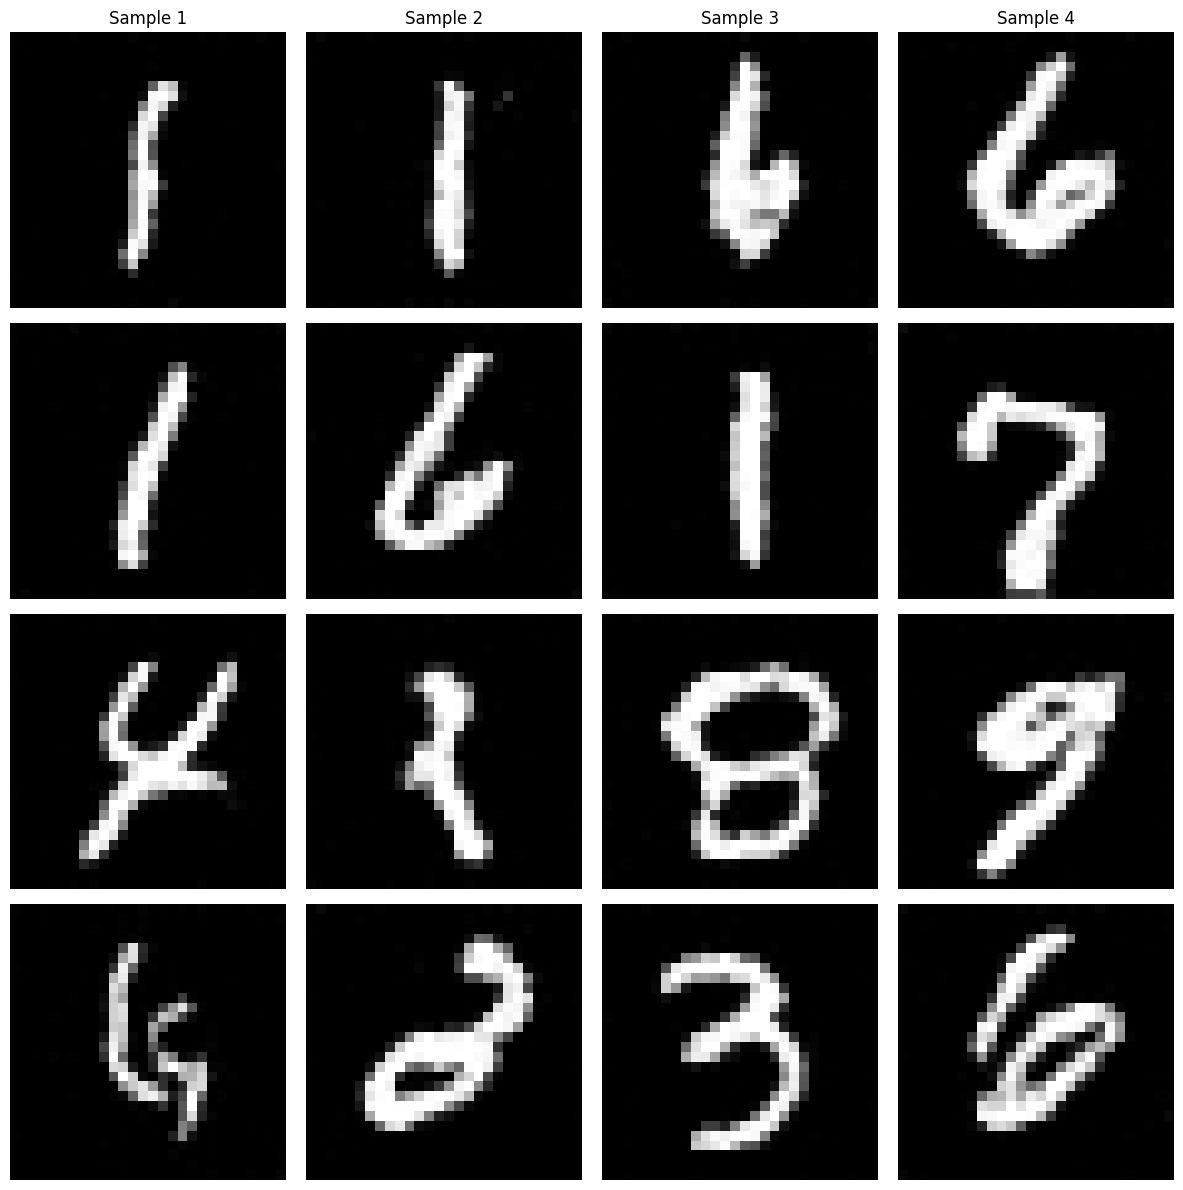

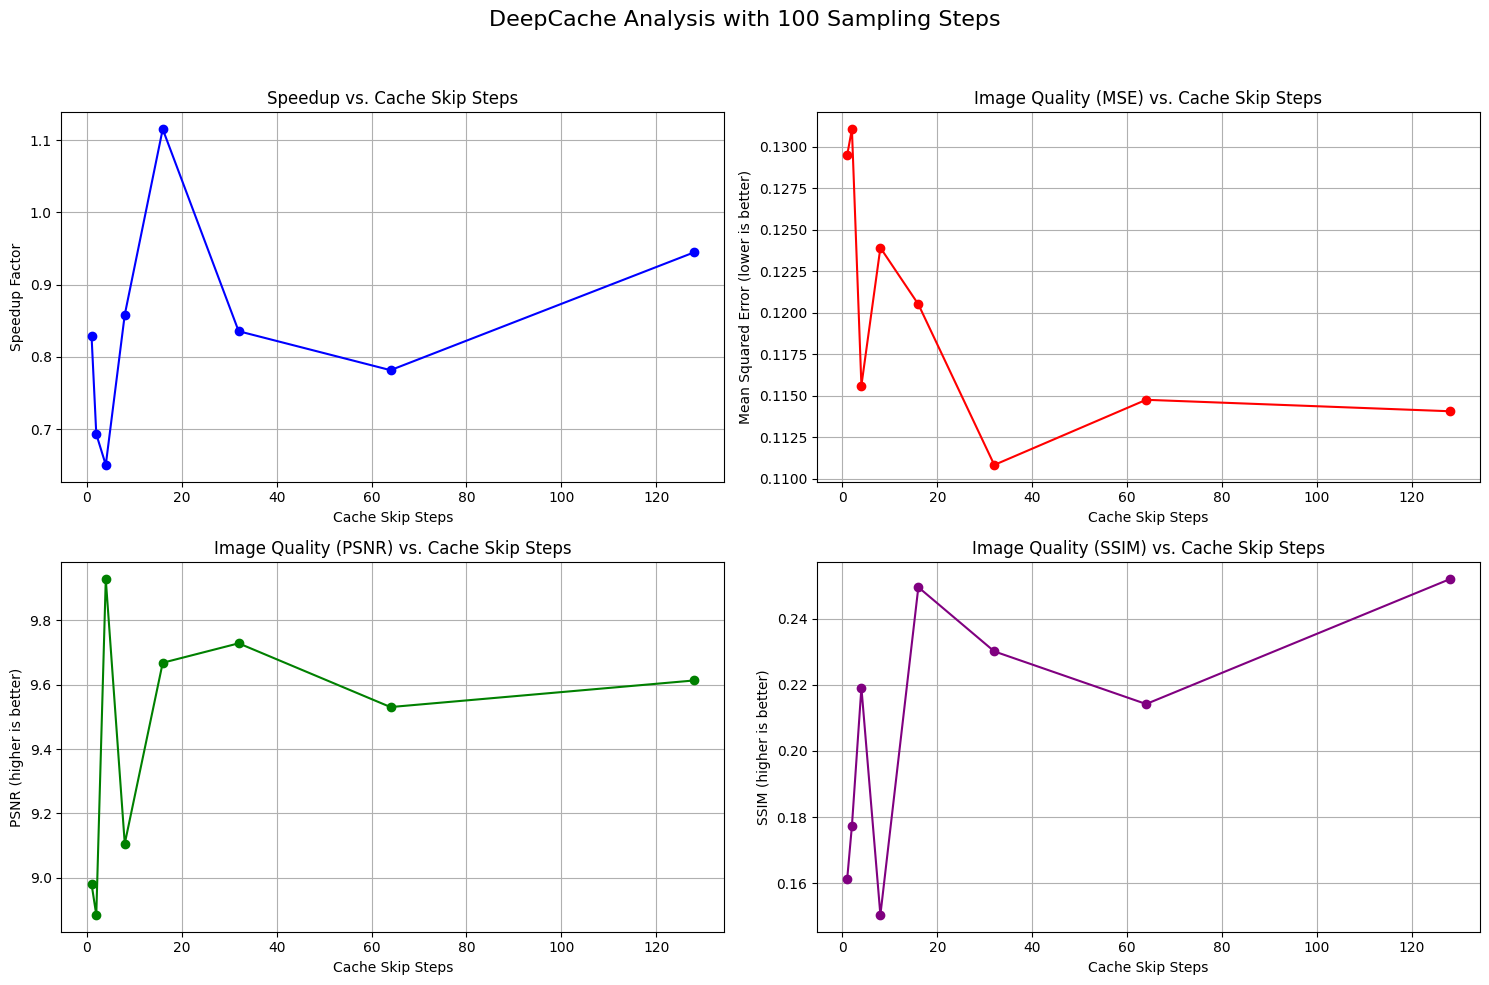

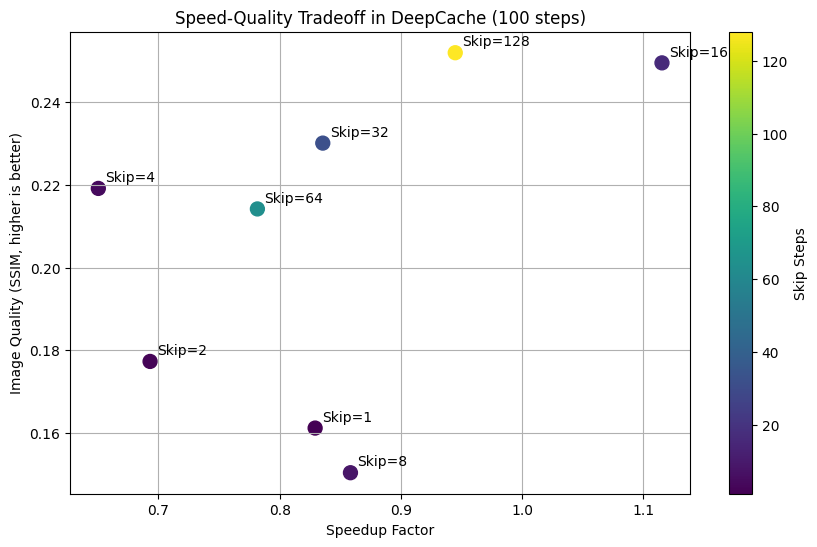

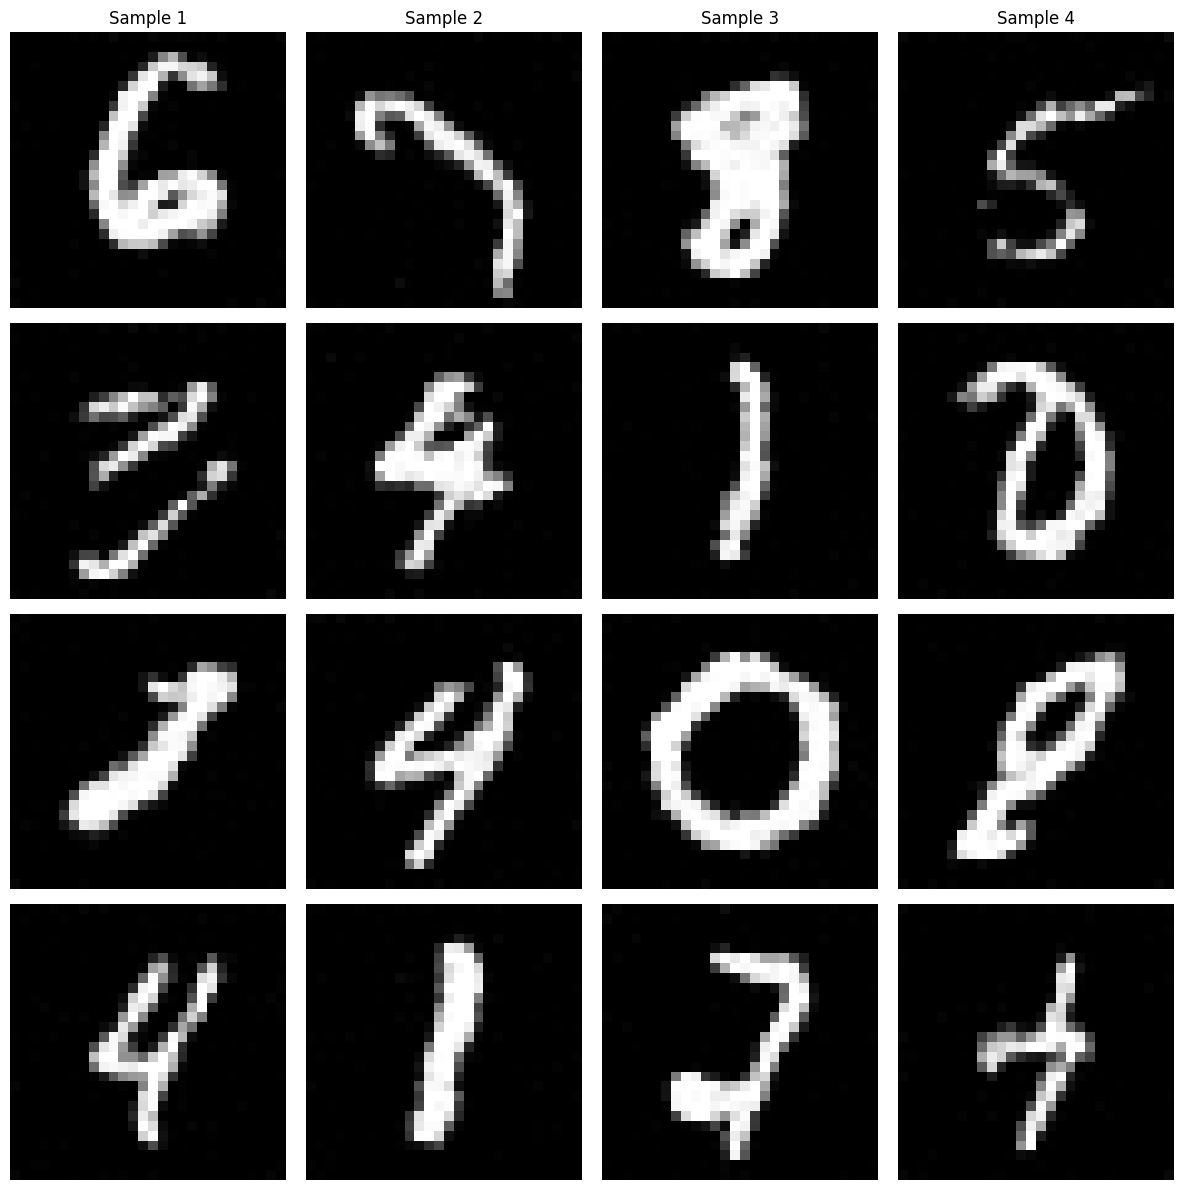

In [26]:
def compute_image_metrics(img1, img2):
    """Compute various image quality metrics between two images"""
    img1_np = img1.squeeze().cpu().numpy()
    img2_np = img2.squeeze().cpu().numpy()
    
    mse = mean_squared_error(img1_np, img2_np)
    
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel) - 10 * np.log10(mse) if mse > 0 else 100
    
    ssim_value = ssim(img1_np, img2_np, data_range=1.0)
    
    return {
        'mse': mse,
        'psnr': psnr,
        'ssim': ssim_value
    }

def analyze_deepcache_tradeoffs(model, steps=[100], skip_steps_range=[1, 2, 4, 8, 16, 32, 64], num_samples=8):
    """Analyze the tradeoff between DeepCache skip steps and image quality"""
    device = next(model.parameters()).device
    
    results = {}
    
    for step_count in steps:
        results[step_count] = []
        
        print(f"Generating baseline samples with {step_count} steps...")
        baseline_samples, baseline_time, _ = model.generate_samples(
            num_samples=num_samples,
            steps=step_count,
            enable_cache=False
        )
        
        for skip_steps in skip_steps_range:
            print(f"Generating samples with DeepCache (skip={skip_steps}, steps={step_count})...")
            
            start_time = time.time()
            cached_samples, cached_time, cache_hits = model.generate_samples(
                num_samples=num_samples,
                steps=step_count,
                enable_cache=True,
                cache_skip_steps=skip_steps
            )
            total_time = time.time() - start_time
            
            metrics = []
            for i in range(num_samples):
                metric = compute_image_metrics(baseline_samples[i], cached_samples[i])
                metrics.append(metric)
            
            avg_metrics = {
                'mse': np.mean([m['mse'] for m in metrics]),
                'psnr': np.mean([m['psnr'] for m in metrics]),
                'ssim': np.mean([m['ssim'] for m in metrics]),
            }
            
            total_cache_hits = sum(cache_hits.values())
            
            results[step_count].append({
                'skip_steps': skip_steps,
                'baseline_time': baseline_time,
                'cached_time': cached_time,
                'speedup': baseline_time / cached_time,
                'metrics': avg_metrics,
                'cache_hits': cache_hits,
                'total_cache_hits': total_cache_hits,
                'samples': cached_samples
            })
    
    return results

def plot_deepcache_analysis(analysis_results):
    """Create plots to visualize the DeepCache analysis results"""
    for step_count, results in analysis_results.items():
        skip_steps = [r['skip_steps'] for r in results]
        speedups = [r['speedup'] for r in results]
        mse_values = [r['metrics']['mse'] for r in results]
        psnr_values = [r['metrics']['psnr'] for r in results]
        ssim_values = [r['metrics']['ssim'] for r in results]
        
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'DeepCache Analysis with {step_count} Sampling Steps', fontsize=16)
        
        axs[0, 0].plot(skip_steps, speedups, 'o-', color='blue')
        axs[0, 0].set_xlabel('Cache Skip Steps')
        axs[0, 0].set_ylabel('Speedup Factor')
        axs[0, 0].set_title('Speedup vs. Cache Skip Steps')
        axs[0, 0].grid(True)
        
        axs[0, 1].plot(skip_steps, mse_values, 'o-', color='red')
        axs[0, 1].set_xlabel('Cache Skip Steps')
        axs[0, 1].set_ylabel('Mean Squared Error (lower is better)')
        axs[0, 1].set_title('Image Quality (MSE) vs. Cache Skip Steps')
        axs[0, 1].grid(True)
        
        axs[1, 0].plot(skip_steps, psnr_values, 'o-', color='green')
        axs[1, 0].set_xlabel('Cache Skip Steps')
        axs[1, 0].set_ylabel('PSNR (higher is better)')
        axs[1, 0].set_title('Image Quality (PSNR) vs. Cache Skip Steps')
        axs[1, 0].grid(True)
        
        axs[1, 1].plot(skip_steps, ssim_values, 'o-', color='purple')
        axs[1, 1].set_xlabel('Cache Skip Steps')
        axs[1, 1].set_ylabel('SSIM (higher is better)')
        axs[1, 1].set_title('Image Quality (SSIM) vs. Cache Skip Steps')
        axs[1, 1].grid(True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        plt.figure(figsize=(10, 6))
        plt.scatter(speedups, ssim_values, c=skip_steps, cmap='viridis', s=100)
        
        for i, skip in enumerate(skip_steps):
            plt.annotate(f'Skip={skip}', (speedups[i], ssim_values[i]), 
                         xytext=(5, 5), textcoords='offset points')
        
        plt.colorbar(label='Skip Steps')
        plt.xlabel('Speedup Factor')
        plt.ylabel('Image Quality (SSIM, higher is better)')
        plt.title(f'Speed-Quality Tradeoff in DeepCache ({step_count} steps)')
        plt.grid(True)
        
        selected_indices = [0, 2, 4, 6] if len(results) >= 7 else list(range(len(results)))
        selected_results = [results[i] for i in selected_indices]
        
        plt.figure(figsize=(12, 3 * len(selected_results)))
        
        baseline_samples = selected_results[0]['samples'] if selected_results else None
        
        num_cols = 4 
        num_rows = len(selected_results)
        
        for row_idx, result in enumerate(selected_results):
            skip = result['skip_steps']
            speedup = result['speedup']
            ssim = result['metrics']['ssim']
            samples = result['samples']
            
            for col_idx in range(num_cols):
                if col_idx < len(samples):
                    ax = plt.subplot(num_rows, num_cols, row_idx * num_cols + col_idx + 1)
                    
                    if row_idx == 0:
                        ax.set_title(f'Sample {col_idx+1}')
                    
                    if col_idx == 0:
                        if row_idx == 0:
                            ax.set_ylabel(f'Baseline\nNo Cache', fontsize=10)
                        else:
                            ax.set_ylabel(f'Skip={skip}\nSpeedup={speedup:.2f}x\nSSIM={ssim:.4f}', fontsize=10)
                    
                    ax.imshow(samples[col_idx, 0].cpu().numpy(), cmap='gray')
                    ax.axis('off')
        
        plt.tight_layout()
        plt.show()

def optimal_skip_step_recommendation(analysis_results):
    """Provide recommendations for optimal skip step settings"""
    recommendations = {}
    
    # For each step count, find the optimal skip step
    for step_count, results in analysis_results.items():
        # Calculate a score that balances speed and quality
        scores = []
        for result in results:
            speedup = result['speedup']
            ssim = result['metrics']['ssim']
            
            # Create a balanced score (adjust weights as needed)
            # This is a simple example: score = speedup * ssim^2
            # Higher weights on SSIM will prioritize quality over speed
            score = speedup * (ssim ** 2)
            scores.append((score, result['skip_steps'], result))
        

        best_score, best_skip_step, best_result = max(scores, key=lambda x: x[0])
        recommendations[step_count] = {
            'skip_steps': best_skip_step,
            'score': best_score,
            'speedup': best_result['speedup'],
            'quality': best_result['metrics']
        }
    
    return recommendations


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

step_values = [1, 10, 20, 50, 100]  
skip_steps_range = [1, 2, 4, 8, 16, 32, 64, 128] 
num_samples = 8  

print("Running DeepCache tradeoff analysis...")
analysis_results = analyze_deepcache_tradeoffs(
    model=model,
    steps=step_values,
    skip_steps_range=skip_steps_range,
    num_samples=num_samples
)

torch.save(analysis_results, "deepcache_analysis_results.pt")
print("Analysis results saved to 'deepcache_analysis_results.pt'")

recommendations = optimal_skip_step_recommendation(analysis_results)

print("\nRecommended DeepCache Settings:")
print("-" * 60)
print(f"{'Step Count':<10} | {'Optimal Skip':<12} | {'Speedup':<8} | {'SSIM':<8}")
print("-" * 60)

for step_count, rec in recommendations.items():
    print(f"{step_count:<10} | {rec['skip_steps']:<12} | {rec['speedup']:.2f}x | {rec['quality']['ssim']:.4f}")

print("\nGenerating visualization plots...")
plot_deepcache_analysis(analysis_results)

## (3pt.) Implement and train conditioning with ControlNet using canny edges

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | unet       | UNet       | 948 K  | train
1 | controlnet | ControlNet | 1.2 M  | train
--------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.485     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/tmp/ipykernel_2331/942461917.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pa

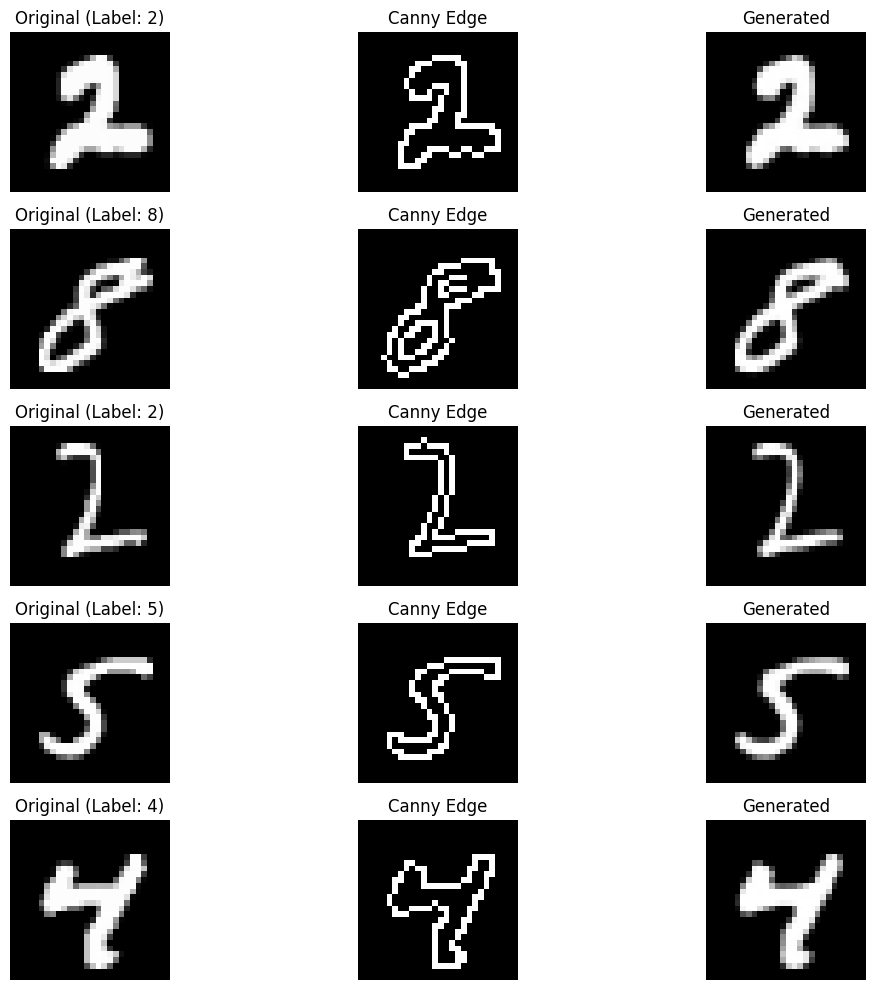

In [30]:
from models.control_net import ControlNet
from models.unet import UNetForControlNet

pl.seed_everything(42)
BATCH_SIZE = 64
NUM_EPOCHS = 10
LATENT_DIM = 64
IMAGE_SIZE = 28
LOG_IMAGES_EVERY_N_STEPS = 100

class CannyEdgeMNIST(Dataset):
    def __init__(self, root_dir, train=True, transform=None, download=True, low_threshold=50, high_threshold=150):
        self.mnist = datasets.MNIST(root=root_dir, train=train, transform=transform, download=download)
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        img_np = (img.squeeze().numpy() * 255).astype(np.uint8)
        edge = cv2.Canny(img_np, self.low_threshold, self.high_threshold)
        edge_tensor = torch.from_numpy(edge).float() / 255.0
        edge_tensor = edge_tensor.unsqueeze(0)
        
        return img, edge_tensor, label




class ControlNetMNIST(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.unet = UNetForControlNet()
        self.controlnet = ControlNet()
        self.lr = lr
        
    def forward(self, img, control):
        control_features = self.controlnet(control)
        return self.unet(img, control_features)
    
    def training_step(self, batch, batch_idx):
        img, edge, _ = batch

        zeros = torch.zeros_like(img)
        generated = self(zeros, edge)

        loss = F.l1_loss(generated, img)
        
        self.log('train_loss', loss)

        if batch_idx % LOG_IMAGES_EVERY_N_STEPS == 0:
            n_examples = min(5, img.size(0))
            fig, axs = plt.subplots(n_examples, 3, figsize=(12, 2*n_examples))
            
            for i in range(n_examples):
                axs[i, 0].imshow(img[i].cpu().squeeze(), cmap='gray')
                axs[i, 0].set_title('Original')
                axs[i, 0].axis('off')

                axs[i, 1].imshow(edge[i].cpu().squeeze(), cmap='gray')
                axs[i, 1].set_title('Canny Edge')
                axs[i, 1].axis('off')

                axs[i, 2].imshow(generated[i].detach().cpu().squeeze(), cmap='gray')
                axs[i, 2].set_title('Generated')
                axs[i, 2].axis('off')
            
            plt.tight_layout()
            plt.close(fig)
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        img, edge, _ = batch
        
        zeros = torch.zeros_like(img)
        generated = self(zeros, edge)
        
        val_loss = F.l1_loss(generated, img)
        self.log('val_loss', val_loss)
        
        if batch_idx == 0:
            n_examples = min(5, img.size(0))
            fig, axs = plt.subplots(n_examples, 3, figsize=(12, 2*n_examples))
            
            for i in range(n_examples):
                axs[i, 0].imshow(img[i].cpu().squeeze(), cmap='gray')
                axs[i, 0].set_title('Original')
                axs[i, 0].axis('off')
                
                axs[i, 1].imshow(edge[i].cpu().squeeze(), cmap='gray')
                axs[i, 1].set_title('Canny Edge')
                axs[i, 1].axis('off')
                
                axs[i, 2].imshow(generated[i].detach().cpu().squeeze(), cmap='gray')
                axs[i, 2].set_title('Generated')
                axs[i, 2].axis('off')
            
            plt.tight_layout()
            plt.close(fig)
            
        
        return val_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

def train_controlnet():

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    train_dataset = CannyEdgeMNIST(root_dir='./data', train=True, 
                                   transform=transform, download=True)
    val_dataset = CannyEdgeMNIST(root_dir='./data', train=False,
                                transform=transform, download=True)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)
    
    model = ControlNetMNIST()
    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='controlnet-mnist-{epoch:02d}-{val_loss:.4f}',
        save_top_k=3,
        mode='min'
    )
    
    
    trainer = pl.Trainer(
        max_epochs=NUM_EPOCHS,
        callbacks=[checkpoint_callback],
        accelerator='auto', 
    )
    

    trainer.fit(model, train_loader, val_loader)
    torch.save(model.state_dict(), 'controlnet_mnist_final.pt')
    
    return model

def test_controlnet(model_path='controlnet_mnist_final.pt'):
    model = ControlNetMNIST()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    test_dataset = CannyEdgeMNIST(root_dir='./data', train=False, 
                                 transform=transforms.ToTensor(), download=True)
    test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)
    imgs, edges, labels = next(iter(test_loader))
    
    with torch.no_grad():
        zeros = torch.zeros_like(imgs)
        generated = model(zeros, edges)
    
    fig, axs = plt.subplots(5, 3, figsize=(12, 10))
    
    for i in range(5):
        axs[i, 0].imshow(imgs[i].squeeze(), cmap='gray')
        axs[i, 0].set_title(f'Original (Label: {labels[i].item()})')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(edges[i].squeeze(), cmap='gray')
        axs[i, 1].set_title('Canny Edge')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(generated[i].squeeze(), cmap='gray')
        axs[i, 2].set_title('Generated')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('controlnet_mnist_test.png')
    plt.show()

model = train_controlnet()
test_controlnet()